In [25]:
# Імпорт необхідних бібліотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
import warnings
import torch
import math
from scipy.stats import pearsonr, spearmanr
from tabulate import tabulate

# Вимкнення попереджень
warnings.filterwarnings('ignore')

# TensorFlow
from tensorflow import keras
from tensorflow.keras import layers, Sequential, optimizers, metrics, callbacks

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

# Моделі машинного навчання
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge, SGDRegressor, ElasticNet, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

# Boosting
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Додаткові імпорти
from kan import *

In [26]:
# функція для перетворення з експоненційної форми у класичну х * 10^y
def to_scientific_notation(number):
    if number == 0:
        return "0"
    exponent = math.floor(math.log10(abs(number)))
    mantissa = number / (10 ** exponent)
    return f"{mantissa:.5f} × 10^{exponent}"


epoch_count = 50


# кастомний колбек для виводу інформації кожні N епох (нейронки)
class CustomMetricsCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.epoch_count == 0:
            predictions = self.model.predict(self.X_test)
            r2 = r2_score(self.y_test, predictions)
            mse = mean_squared_error(self.y_test, predictions)
            mae = mean_absolute_error(self.y_test, predictions)
            age_diff = abs(self.y_test.values.ravel() - predictions.ravel())
            # avg_age_diff = age_diff.mean()
            # Отримати максимальну та мінімальну різницю між передбаченим віком і реальним
            max_age_diff = age_diff.max()
            min_age_diff = age_diff.min()
            print(f"Epoch {epoch}: Loss(Train {self.loss_name}) - {logs['loss']:.4f} | MAE - {mae:.4f} [{max_age_diff:.4f}<>{min_age_diff:.4f}] | MSE - {mse:.4f} | R2 - {r2:.4f}")
            print(f'[{self.y_test.iloc[0]}, {predictions[0][0]:.3f}], [{self.y_test.iloc[1]}, {predictions[1][0]:.3f}], [{self.y_test.iloc[2]}, {predictions[2][0]:.3f}], [{self.y_test.iloc[3]}, {predictions[3][0]:.3f}], [{self.y_test.iloc[4]}, {predictions[4][0]:.3f}]')


# проміжний вивід результатів у зручному форматі
def show_result(y_test, prediction, execution_time, plot_name='', x_label='', y_label=''):
    # Оцінка точності за допомогою MAE
    mae = mean_absolute_error(y_test, prediction)
    # Оцінка точності за допомогою MSE
    mse = mean_squared_error(y_test, prediction)
    # Оцінка точності за допомогою R-squared (R2) score
    r2 = r2_score(y_test, prediction)

    age_diff = abs(y_test.values.ravel() - prediction.ravel())

    max_age_diff = age_diff.max()
    min_age_diff = age_diff.min()

    comparison_df = pd.DataFrame({'Age': y_test, 'Prediction': prediction.flatten()})
    
    # Оцінка точності за допомогою кореляції
    correlation = comparison_df['Age'].corr(comparison_df['Prediction'])

    print('Model results:')
    print('R2:', r2)
    print('MAE:', mae, '| MAX: ', max_age_diff, '| MIN: ', min_age_diff)
    print('MSE:', mse)
    print('Correlation:', correlation)
    print(f'Час виконання: {execution_time} секунд.')

    column_width = 15

    print('|{:<{}}|{:<{}}|'.format('Real age', column_width, 'Predicted', column_width))
    print('|{:<{}}|{:<{}}|'.format('-' * column_width, column_width, '-' * column_width, column_width))

    for i in range(5):
        real_age = y_test.iloc[i]
        predicted_age = prediction[i][0]
        formatted_real_age = '{:.3f}'.format(real_age)
        formatted_predicted_age = '{:.3f}'.format(predicted_age)
        print('|{:<{}}|{:<{}}|'.format(formatted_real_age, column_width, formatted_predicted_age, column_width))

    plt.style.use('ggplot')

    fig, ax = plt.subplots(figsize=(7, 5))

    ax.scatter(y_test, prediction, color='k', edgecolor='k', facecolor='grey', alpha=0.7)
    ax.plot(y_test, y_test, color='r', linestyle='--', linewidth=2)

    if plot_name != '':
        ax.set_title(str(plot_name)+f' (кореляція = {correlation:.2f})', fontsize=14)
    else:
        ax.set_title(f"Кореляція між хронологічним та біологічним віком (кореляція = {correlation:.2f})")

    if x_label != '':
        ax.set_xlabel(x_label, fontsize=10)
    else:
        ax.set_xlabel('Реальний вік', fontsize=10)

    if y_label != '':
        ax.set_ylabel(y_label, fontsize=10)
    else:
        ax.set_ylabel('Прогнозований вік', fontsize=10)

    plt.tight_layout()
    plt.show()


def evaluate_metrics(execution_time, preds, labels, label=""):
    preds_np = preds.numpy()
    labels_np = labels.numpy()

    r2 = r2_score(labels_np, preds_np)
    mae = mean_absolute_error(labels_np, preds_np)
    mse = mean_squared_error(labels_np, preds_np)
    corr, _ = pearsonr(labels_np.flatten(), preds_np.flatten())  # Flatten для векторів

    print(f"{label} R2: {r2}")
    print(f"{label} MAE: {mae}")
    print(f"{label} MSE: {mse}")
    print(f"{label} Correlation: {corr}")
    print(f"Time: {execution_time}")
    print("-" * 50)

In [ ]:
df_male = pd.read_excel('datasets/UA/Ecg.xlsx',
                          sheet_name='male',
                          names=['Age',
                                 'Heart rate (contractions / ms)',
                                 'PQ (ms)',
                                 'PQ CoefVar (%)',
                                 'RR (ms)',
                                 'ST (ms)',
                                 'QRS (ms)',
                                 'P (ms)',
                                 'T (ms)',
                                 'P amplitude (mV)',
                                 'R amplitude (mV)',
                                 'T amplitude (mV)'])

print('Data was imported')

Data was imported


In [28]:
# обчислення кількості пацієнтів на діапазонах по 10 років

df = df_male.copy()

df['Age_Group'] = pd.cut(df['Age'], bins=range(0, 101, 10), right=False)

patients_by_age_group = df['Age_Group'].value_counts().sort_index()

mean = df['Age'].mean()

print('Mean age: ', mean)
print(patients_by_age_group)


Mean age:  59.857971014492755
Age_Group
[0, 10)       0
[10, 20)      0
[20, 30)      0
[30, 40)      0
[40, 50)     75
[50, 60)     99
[60, 70)     96
[70, 80)     58
[80, 90)     17
[90, 100)     0
Name: count, dtype: int64


In [29]:
# Попередня обробка набору даних
print('------------INFO DATAFRAME MALE------------')
print('SIZE: ', df_male.size)
print('ROWS: ', df_male.shape[0])
print('ISNULL: ', df_male.isnull().sum().sum())

# видалити рядки, у яких пропущений вік
df_male = df_male.dropna(subset=['Age'])

# видалити рядки за межами вказаного діапазону віку
df_male = df_male.drop(df_male[df_male['Age'] < 40].index)
df_male = df_male.drop(df_male[df_male['Age'] > 89].index)

# видалити рядки, у яких пропущено 8 або більше полів
df_male = df_male.dropna(thresh=8)

# сортувати за віком
df_male = df_male.sort_values(by='Age')
# інтерполяція пропущених значень
df_male.interpolate(method='polynomial', order=2)
# якщо є пропущені значення по краям, також заповнюємо найближчими
df_male = df_male.ffill()
df_male = df_male.bfill()
# скидаємо індекси та перемішуємо
df_male = df_male.sort_index()
df_male = df_male.sample(frac=1).reset_index(drop=True)
df_male = df_male.reset_index(drop=True)

print('------------INFO DATAFRAME MALE (after)------------')
print('SIZE: ', df_male.size)
print('ROWS: ', df_male.shape[0])
print('ISNULL: ', df_male.isnull().sum().sum())

# для більш зручного виводу
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

display(df_male)

------------INFO DATAFRAME MALE------------
SIZE:  3806
ROWS:  346
ISNULL:  44
------------INFO DATAFRAME MALE (after)------------
SIZE:  3784
ROWS:  344
ISNULL:  0


,Age,BMI,FRAX-all,FRAX-hip,LS-BMD,FN-BMD-R,FN-BMD-L,Hip-BMD-R,Hip-BMD-L,UDR-BMD,TBS
0,64.0,20.447,3.2,1.2,0.676,0.448,0.454,0.670,0.649,0.628,1.296
1,76.0,34.838,3.3,1.2,1.411,0.930,0.884,1.293,1.287,0.715,1.280
2,50.0,28.835,1.9,0.1,1.247,1.052,1.026,1.234,1.212,0.886,1.394
3,71.0,30.487,2.0,0.6,1.155,0.969,1.172,1.282,1.453,0.750,1.330
4,67.0,46.777,1.3,0.2,1.238,0.920,1.031,1.199,1.343,0.779,0.877
...,...,...,...,...,...,...,...,...,...,...,...
339,76.0,21.469,4.9,2.6,0.769,0.540,0.524,0.685,0.621,0.701,1.266
340,58.0,29.055,2.0,0.2,1.295,0.997,0.989,1.310,1.205,0.829,1.500
341,66.0,26.424,2.2,0.5,0.944,0.679,0.657,0.906,0.900,0.784,1.266
342,57.0,19.957,5.0,1.8,1.054,0.683,0.769,0.852,0.948,0.656,1.396


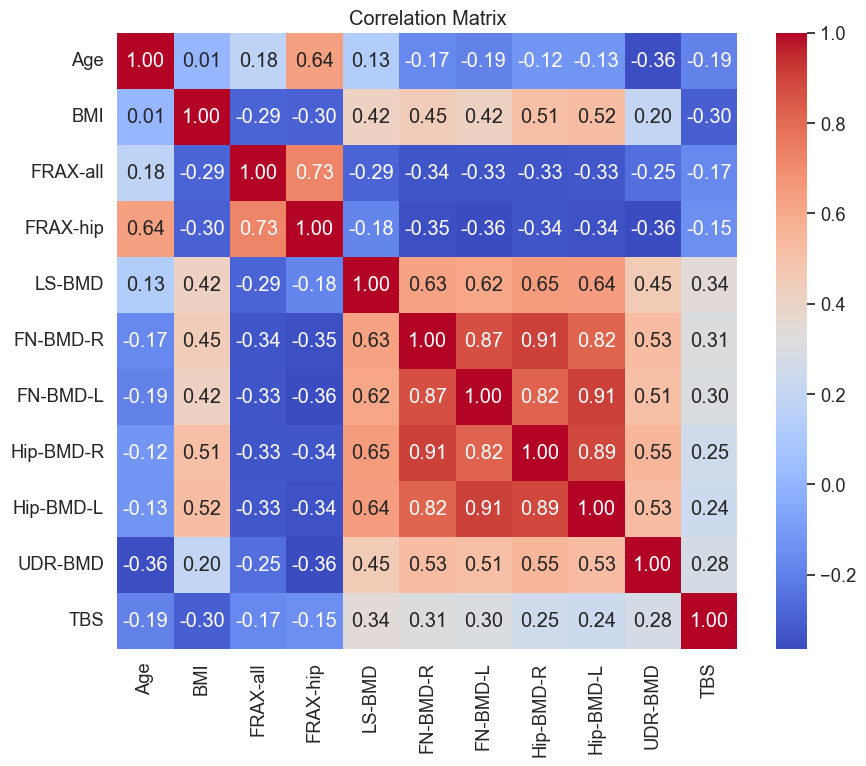

In [18]:
# Обчислення матриці кореляції
correlation_matrix = df_male.corr()

# Побудова теплової карти кореляції
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Matrix')
plt.show()

In [30]:
# Обчислення статистичних параметрів для підтвердження значущості кореляції
target_column = 'Age'

target_sex = df_male

correlation_results = {}

# Обхід всіх колонок, крім цільової
for column in target_sex.columns:
    if column != target_column:
        # Видалити рядки з пропущеними значеннями для поточної колонки
        df_temp = target_sex[[target_column, column]].dropna()

        # Обчислити коефіцієнт кореляції Пірсона та p-значення
        correlation_coefficient_p, p_value_p = pearsonr(df_temp[target_column], df_temp[column])

        correlation_coefficient_s, p_value_s = spearmanr(df_temp[target_column], df_temp[column])

        # Кількість спостережень
        sample_size = len(df_temp)

        # Обчислити t-значення
        t_value_p = correlation_coefficient_p * (sample_size - 2) ** 0.5 / ((1 - correlation_coefficient_p ** 2) ** 0.5)

        t_value_s = correlation_coefficient_s * (sample_size - 2) ** 0.5 / ((1 - correlation_coefficient_s ** 2) ** 0.5)

        # Обчислити похибку стандарту
        standard_error = df_temp[column].sem()

        # Зберегти результати у словнику
        correlation_results[column] = {'mean': df_temp[column].mean(),
                                           'correlation_coefficient_p': correlation_coefficient_p,
                                           'p_value_p': p_value_p,
                                           't_value_p': t_value_p,
                                           'correlation_coefficient_s': correlation_coefficient_s,
                                           'p_value_s': p_value_s,
                                           't_value_s': t_value_s,
                                           'standard_error': standard_error}

# Список списків для tabulate
table_data = [[column,
                round(results['mean'], 3),
                round(results['standard_error'], 3),
                round(results['correlation_coefficient_p'], 3),
                to_scientific_notation(results['p_value_p']),
                round(results['t_value_p'], 5),
                round(results['correlation_coefficient_s'], 3),
                to_scientific_notation(results['p_value_s']),
                round(results['t_value_s'], 5)] for column, results in correlation_results.items()]

# Вивід табличних даних
print(tabulate(table_data, headers=['Param', 'mean', 'SE',
                                    'P Corr', 'P p', 'P t',
                                    'S Corr', 'S p', 'S t'],
                tablefmt='fancy_grid'))


╒═══════════╤════════╤═══════╤══════════╤══════════════════╤══════════╤══════════╤══════════════════╤══════════╕
│ Param     │   mean │    SE │   P Corr │ P p              │      P t │   S Corr │ S p              │      S t │
╞═══════════╪════════╪═══════╪══════════╪══════════════════╪══════════╪══════════╪══════════════════╪══════════╡
│ BMI       │ 27.182 │ 0.243 │    0.012 │ 8.30618 × 10^-1  │  0.21407 │    0.008 │ 8.84701 × 10^-1  │  0.14512 │
├───────────┼────────┼───────┼──────────┼──────────────────┼──────────┼──────────┼──────────────────┼──────────┤
│ FRAX-all  │  3.174 │ 0.085 │    0.176 │ 1.05890 × 10^-3  │  3.30267 │    0.231 │ 1.53804 × 10^-5  │  4.38619 │
├───────────┼────────┼───────┼──────────┼──────────────────┼──────────┼──────────┼──────────────────┼──────────┤
│ FRAX-hip  │  0.771 │ 0.044 │    0.636 │ 2.55892 × 10^-40 │ 15.2229  │    0.726 │ 1.17256 × 10^-57 │ 19.5464  │
├───────────┼────────┼───────┼──────────┼──────────────────┼──────────┼──────────┼──────────────

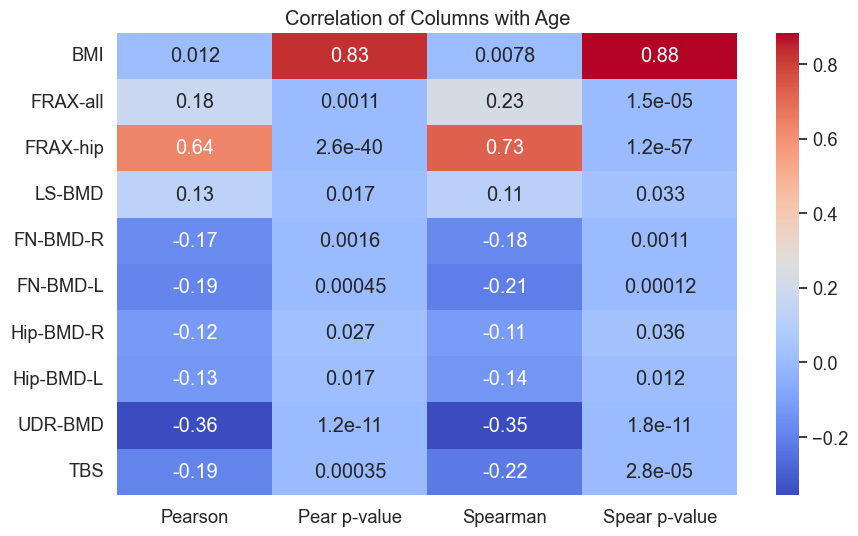

In [31]:
# Кореляція та p-value для всіх полів окрім віку
columns_to_compare = df_male.drop('Age', axis=1).columns

correlations_pearson = {}
p_values_pearson = {}
correlations_spearman = {}
p_values_spearman = {}

for column in columns_to_compare:
    correlations_pearson[column], p_values_pearson[column] = pearsonr(df_male.dropna()[column], df_male.dropna()['Age'])

    sample_size = len(df_male)

    correlations_spearman[column], p_values_spearman[column] = spearmanr(df_male.dropna()[column], df_male.dropna()['Age'])

# Побудова теплової карти кореляції
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.2)
sns.heatmap(pd.DataFrame({'Pearson': correlations_pearson, 
                          'Pear p-value': p_values_pearson,
                          'Spearman': correlations_spearman,
                          'Spear p-value': p_values_spearman}),
            annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation of Columns with Age')
plt.show()

In [ ]:
# Залишити лише рядки з високою кореляцією
df_male = df_male[['Age', 'Heart rate (contractions / ms)', 'RR (ms)', 'ST (ms)',  'QRS (ms)', 'R amplitude (mV)', 'T amplitude (mV)']]


In [33]:
X = df_male.drop(columns=['Age'])
y = df_male[['Age']]

# Розбиваємо на вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=20)

X_test = pd.DataFrame([[0.2, 0.826, 0.816],[0.6,0.716, 0.755],[0.1, 0.882, 0.758], [0.1, 0.902, 0.801], [0.4, 0.719, 0.666]], columns=['FRAX-hip', 'FN-BMD-R', 'UDR-BMD'])


y_test = pd.DataFrame([[40],[50],[45], [55], [75]], columns=['Age'])




# Скалюємо від -1 до 1, центрування до 0
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Розмір X_train: {X_train.shape}")
print(f"Розмір X_test: {X_test.shape}")

Розмір X_train: (258, 3)
Розмір X_test: (5, 3)


In [34]:
df_scale_test = pd.DataFrame(X_train_scaled, columns=df_male.columns[1:])
display(df_scale_test)

,FRAX-hip,FN-BMD-R,UDR-BMD
0,0.159,0.928,1.338
1,-0.837,0.235,0.363
2,-0.090,2.096,0.953
3,-0.339,-0.676,-0.566
4,-0.090,-0.163,0.919
...,...,...,...
253,-0.837,-0.721,-0.442
254,0.906,-0.696,1.225
255,-0.588,0.036,0.522
256,-0.837,0.761,1.050


In [35]:
# ----------------FIND BEST PARAMS FOR MALE----------------
models = [
    ('KNeighborsRegressor', KNeighborsRegressor()),
    ('GradientBoostingRegressor', GradientBoostingRegressor()),
    ('RandomForestRegressor', RandomForestRegressor()),
    ('XGBRegressor', XGBRegressor()),
    ('LGBMRegressor', LGBMRegressor()),
    ('CatBoostRegressor', CatBoostRegressor()),
    ('AdaBoostRegressor', AdaBoostRegressor()),
    ('BaggingRegressor', BaggingRegressor()),
    ('BayesianRidge', BayesianRidge()),
    ('ElasticNet', ElasticNet()),
    ('PLSRegression', PLSRegression()),
    ('DecisionTreeRegressor', DecisionTreeRegressor()),
    ('Lasso', Lasso()),
    ('MLPRegressor', MLPRegressor())
]

param_grid = {
    'KNeighborsRegressor': {
        'n_neighbors': [5, 15, 25]
        },
    'GradientBoostingRegressor': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5]
        },
    'RandomForestRegressor': {
        'n_estimators': [200, 300, 500],
        'max_depth': [5, 10, 20]
        },
    'XGBRegressor': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.2]
        },
    'LGBMRegressor': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.2],
        'verbose': [-1],
        },
    'CatBoostRegressor': {
        'iterations': [100, 200, 300, 500],
        'depth': [5, 10, 20],
        'learning_rate': [0.01, 0.1, 0.2],
        'verbose': [False],
        },
    'AdaBoostRegressor': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.5],
        'estimator': [XGBRegressor()],
        },
    'BaggingRegressor': {
        'n_estimators': [100, 200, 500],
        'max_samples': [0.5, 0.7, 1.0]
        },
    'BayesianRidge': {
        'alpha_1': [1e-6, 1e-7, 1e-8],
        'alpha_2': [1e-6, 1e-7, 1e-8],
        'lambda_1': [1e-6, 1e-7, 1e-8],
        'lambda_2': [1e-6, 1e-7, 1e-8]
    },
    'ElasticNet': {
        'alpha': [0.001, 0.01, 0.1, 1],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
        'max_iter': [500, 1000]
    },
    'PLSRegression': {
        'n_components': [1, 2, 3, 4, 5]
    },
    'DecisionTreeRegressor': {
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'Lasso': {
        'alpha': [0.001, 0.01, 0.1, 1]
    },
    'MLPRegressor': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (50, 100, 50)],
        'alpha': [0.001, 0.01],
        'max_iter': [500, 1000, 3000],
        'solver': ['adam'],
        'activation': ['relu'],
    },
}

best_params_male = {}

for model_name, model in models:
    param_grid_model = param_grid[model_name]

    grid_search = GridSearchCV(model, param_grid_model, scoring='neg_mean_squared_error', cv=4)
    grid_search.fit(X_train_scaled, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    best_model = grid_search.best_estimator_




    ###################################################
    y_pred = best_model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    ###################################################






    best_params_male[model_name] = best_params

    print(f"Найкращі параметри для {model_name}: {best_params}")
    print(f"Найкращий результат (MSE) для {model_name}: {best_score}")
    print(f"MSE на тестовому наборі для {model_name}: {mse}")
    print("-" * 50)

Найкращі параметри для KNeighborsRegressor: {'n_neighbors': 15}
Найкращий результат (MSE) для KNeighborsRegressor: -76.70383066239316
MSE на тестовому наборі для KNeighborsRegressor: 136.07822222222222
--------------------------------------------------
Найкращі параметри для GradientBoostingRegressor: {'max_depth': 3, 'n_estimators': 100}
Найкращий результат (MSE) для GradientBoostingRegressor: -69.22257699777381
MSE на тестовому наборі для GradientBoostingRegressor: 104.20709183826402
--------------------------------------------------
Найкращі параметри для RandomForestRegressor: {'max_depth': 5, 'n_estimators': 300}
Найкращий результат (MSE) для RandomForestRegressor: -63.036944718991904
MSE на тестовому наборі для RandomForestRegressor: 107.50337231792506
--------------------------------------------------
Найкращі параметри для XGBRegressor: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Найкращий результат (MSE) для XGBRegressor: -62.99466609954834
MSE на тестовому на

--------------------------------
KNeighborsRegressor
Model results:
R2: 0.06795738203957391
MAE: 10.426666666666666 | MAX:  18.266666666666666 | MIN:  3.2666666666666657
MSE: 136.07822222222222
Correlation: 0.312123450317362
Час виконання: 0.004987955093383789 секунд.
|Real age       |Predicted      |
|---------------|---------------|
|40.000         |54.067         |
|50.000         |59.133         |
|45.000         |52.400         |
|55.000         |51.733         |
|75.000         |56.733         |


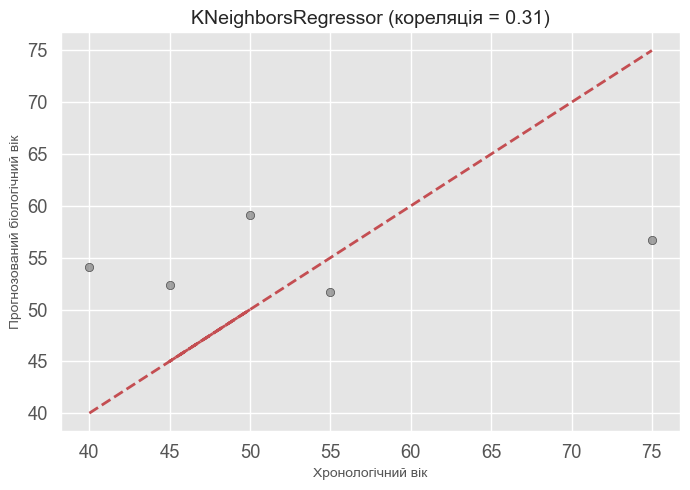

GradientBoostingRegressor
Model results:
R2: 0.2862527956283286
MAE: 9.0840999535329 | MAX:  14.230382434114432 | MIN:  1.9147301408443624
MSE: 104.20709183826402
Correlation: 0.545477684135685
Час виконання: 0.15287995338439941 секунд.
|Real age       |Predicted      |
|---------------|---------------|
|40.000         |54.230         |
|50.000         |58.185         |
|45.000         |46.915         |
|55.000         |48.024         |
|75.000         |60.886         |


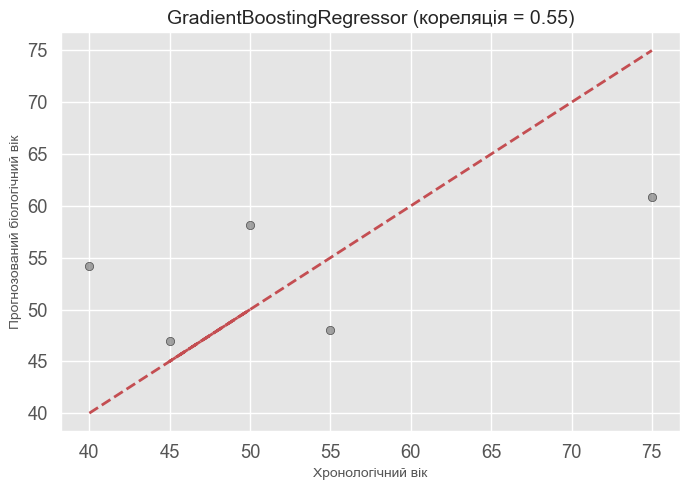

RandomForestRegressor
Model results:
R2: 0.23119933355462063
MAE: 9.245919772974094 | MAX:  16.01428050765189 | MIN:  1.6586193309181212
MSE: 112.24489730102539
Correlation: 0.48403094863480467
Час виконання: 0.5908598899841309 секунд.
|Real age       |Predicted      |
|---------------|---------------|
|40.000         |56.014         |
|50.000         |57.025         |
|45.000         |46.659         |
|55.000         |47.463         |
|75.000         |61.005         |


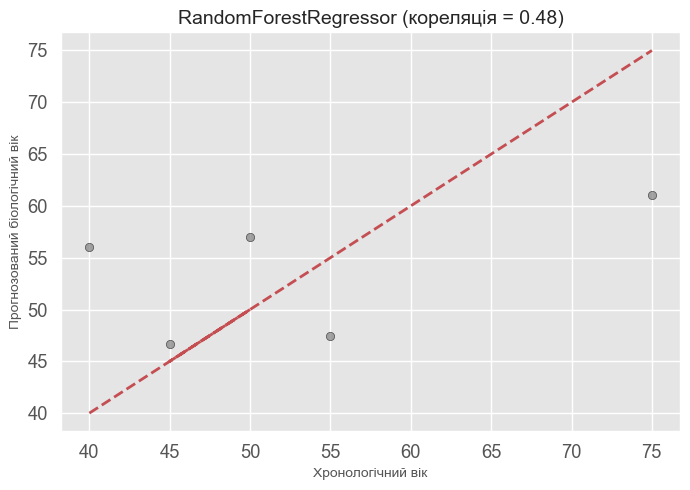

XGBRegressor
Model results:
R2: 0.2646322250366211
MAE: 9.294515609741211 | MAX:  14.794975280761719 | MIN:  2.8460121154785156
MSE: 107.36369323730469
Correlation: 0.5278562712223711
Час виконання: 0.21154212951660156 секунд.
|Real age       |Predicted      |
|---------------|---------------|
|40.000         |54.795         |
|50.000         |57.423         |
|45.000         |47.846         |
|55.000         |47.871         |
|75.000         |60.721         |


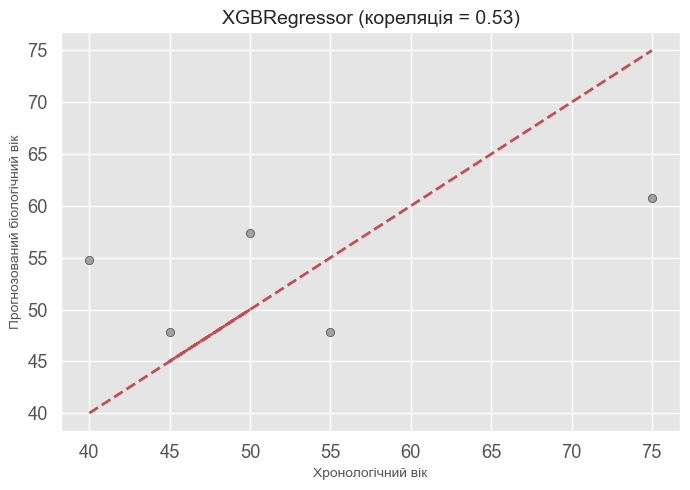

LGBMRegressor
Model results:
R2: 0.28530393491939554
MAE: 8.826838784752617 | MAX:  15.281473267461742 | MIN:  1.8903289506934868
MSE: 104.34562550176824
Correlation: 0.5594440583531898
Час виконання: 0.05684685707092285 секунд.
|Real age       |Predicted      |
|---------------|---------------|
|40.000         |54.295         |
|50.000         |56.484         |
|45.000         |46.890         |
|55.000         |48.817         |
|75.000         |59.719         |


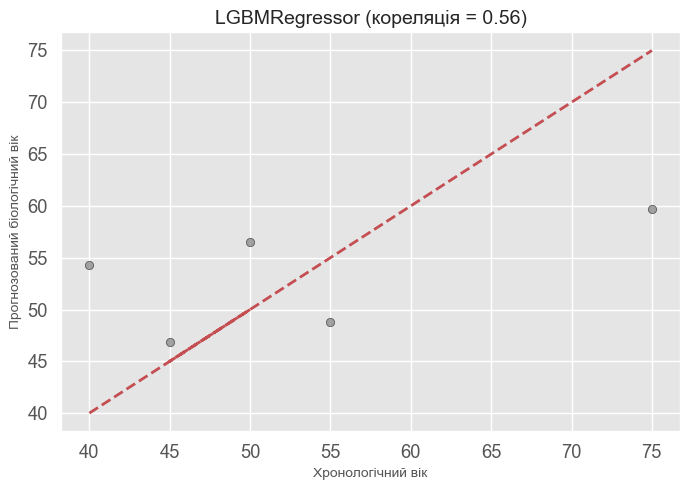

CatBoostRegressor
Model results:
R2: 0.27031725691559694
MAE: 9.178726960829037 | MAX:  15.586072105658339 | MIN:  2.29454800028806
MSE: 106.53368049032285
Correlation: 0.5353997348051527
Час виконання: 0.7287101745605469 секунд.
|Real age       |Predicted      |
|---------------|---------------|
|40.000         |53.216         |
|50.000         |57.810         |
|45.000         |47.295         |
|55.000         |48.013         |
|75.000         |59.414         |


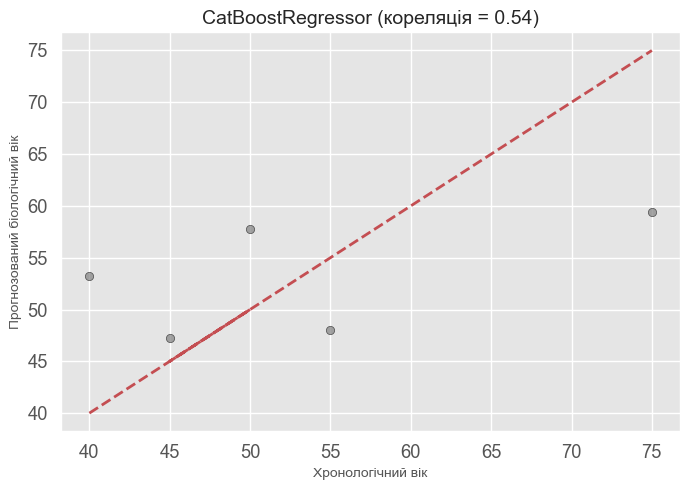

AdaBoostRegressor
Model results:
R2: 0.1523042917251587
MAE: 9.151498794555664 | MAX:  19.981727600097656 | MIN:  1.6509857177734375
MSE: 123.7635726928711
Correlation: 0.435530806192315
Час виконання: 7.798485040664673 секунд.
|Real age       |Predicted      |
|---------------|---------------|
|40.000         |59.982         |
|50.000         |51.651         |
|45.000         |49.141         |
|55.000         |45.033         |
|75.000         |64.984         |


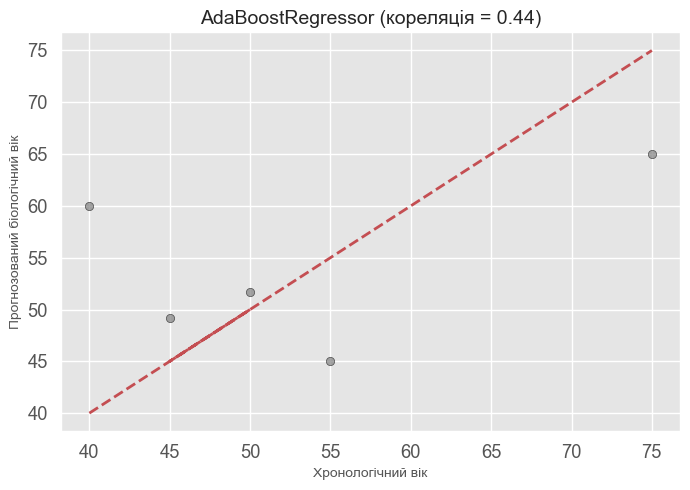

BaggingRegressor
Model results:
R2: 0.30819719178082183
MAE: 8.562000000000001 | MAX:  16.270000000000003 | MIN:  1.7899999999999991
MSE: 101.00321000000001
Correlation: 0.5670480627529243
Час виконання: 0.6248345375061035 секунд.
|Real age       |Predicted      |
|---------------|---------------|
|40.000         |56.270         |
|50.000         |55.075         |
|45.000         |46.790         |
|55.000         |48.145         |
|75.000         |62.180         |


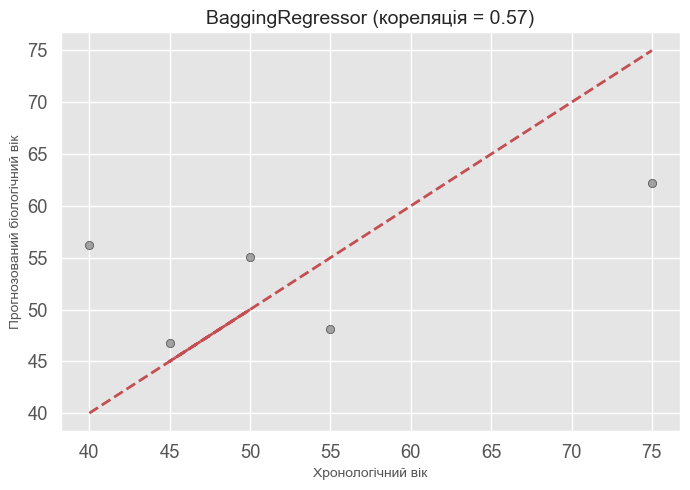

BayesianRidge
Model results:
R2: 0.12176345686426326
MAE: 9.866722619391656 | MAX:  16.699788858506075 | MIN:  0.5827578297397764
MSE: 128.22253529781756
Correlation: 0.6944299474761528
Час виконання: 0.002992391586303711 секунд.
|Real age       |Predicted      |
|---------------|---------------|
|40.000         |53.991         |
|50.000         |57.793         |
|45.000         |55.268         |
|55.000         |54.417         |
|75.000         |58.300         |


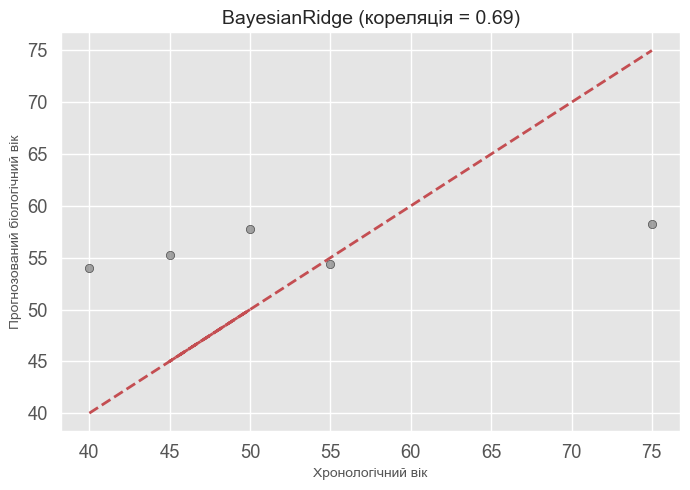

ElasticNet
Model results:
R2: 0.1057608368568308
MAE: 9.944640828302594 | MAX:  16.447047542324476 | MIN:  0.32867582995127975
MSE: 130.5589178189027
Correlation: 0.6881380224019449
Час виконання: 0.0049877166748046875 секунд.
|Real age       |Predicted      |
|---------------|---------------|
|40.000         |54.387         |
|50.000         |58.065         |
|45.000         |55.496         |
|55.000         |54.671         |
|75.000         |58.553         |


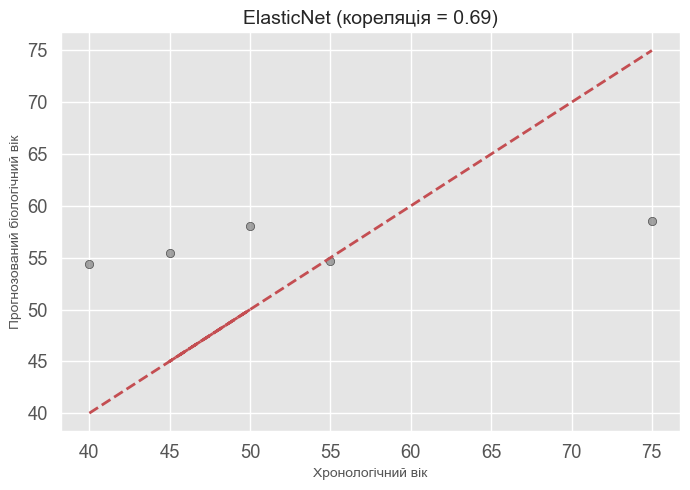

PLSRegression
Model results:
R2: 0.11007706090925506
MAE: 9.92898743709844 | MAX:  17.075124056301725 | MIN:  0.7357913535111678
MSE: 129.92874910724876
Correlation: 0.6454278796703711
Час виконання: 0.0039865970611572266 секунд.
|Real age       |Predicted      |
|---------------|---------------|
|40.000         |54.026         |
|50.000         |57.842         |
|45.000         |54.966         |
|55.000         |54.264         |
|75.000         |57.925         |


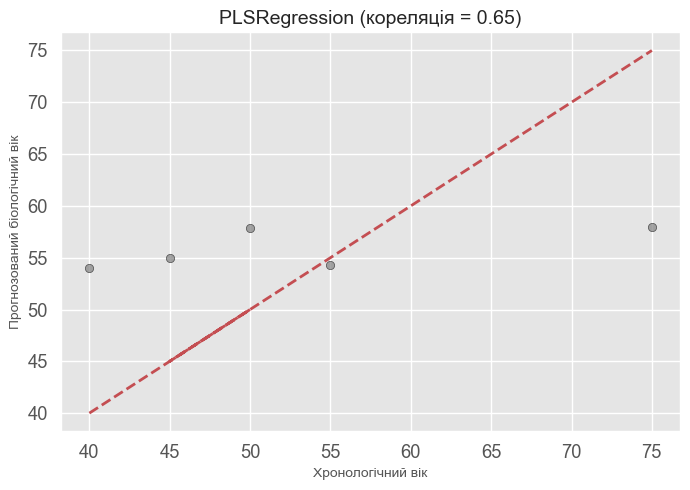

DecisionTreeRegressor
Model results:
R2: 0.3879025525735408
MAE: 7.65952380952381 | MAX:  16.375 | MIN:  1.7142857142857153
MSE: 89.36622732426305
Correlation: 0.6305109980013897
Час виконання: 0.002992868423461914 секунд.
|Real age       |Predicted      |
|---------------|---------------|
|40.000         |56.375         |
|50.000         |47.500         |
|45.000         |46.714         |
|55.000         |48.667         |
|75.000         |63.625         |


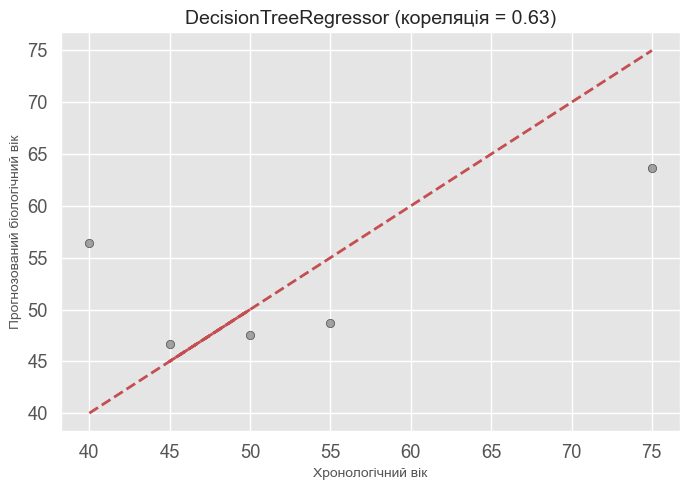

Lasso
Model results:
R2: 0.11676673883760935
MAE: 9.897259743298818 | MAX:  16.78514220421593 | MIN:  0.6202465022704686
MSE: 128.95205612970904
Correlation: 0.6771244965985197
Час виконання: 0.0039904117584228516 секунд.
|Real age       |Predicted      |
|---------------|---------------|
|40.000         |54.047         |
|50.000         |57.854         |
|45.000         |55.180         |
|55.000         |54.380         |
|75.000         |58.215         |


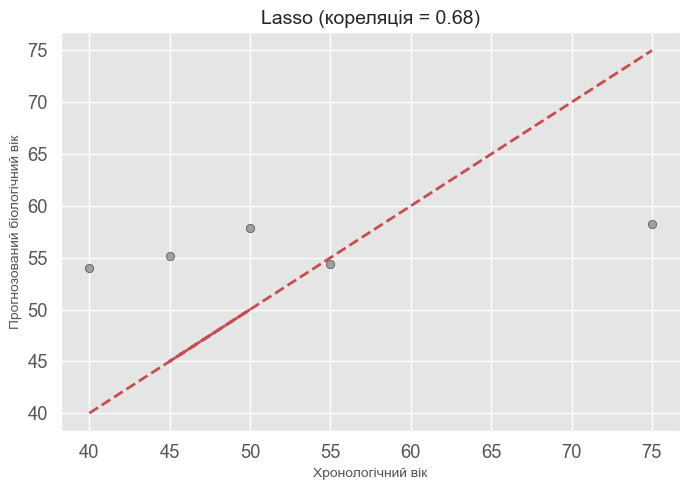

MLPRegressor
Model results:
R2: 0.17589485255540516
MAE: 9.894395940296707 | MAX:  16.528080051270152 | MIN:  2.9612270968612506
MSE: 120.31935152691085
Correlation: 0.4242471490093215
Час виконання: 1.0583815574645996 секунд.
|Real age       |Predicted      |
|---------------|---------------|
|40.000         |52.171         |
|50.000         |61.445         |
|45.000         |47.961         |
|55.000         |48.633         |
|75.000         |58.472         |


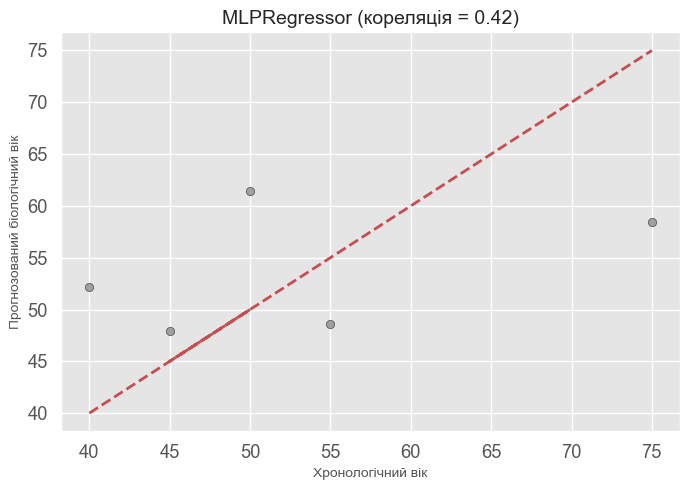

In [36]:
# ----------------TEST THE NETWORKS FOR MALE----------------
models = [
    ('KNeighborsRegressor', KNeighborsRegressor(**best_params_male['KNeighborsRegressor'])),
    ('GradientBoostingRegressor', GradientBoostingRegressor(**best_params_male['GradientBoostingRegressor'])),
    ('RandomForestRegressor', RandomForestRegressor(**best_params_male['RandomForestRegressor'])),
    ('XGBRegressor', XGBRegressor(**best_params_male['XGBRegressor'])),
    ('LGBMRegressor', LGBMRegressor(**best_params_male['LGBMRegressor'])),
    ('CatBoostRegressor', CatBoostRegressor(**best_params_male['CatBoostRegressor'])),
    ('AdaBoostRegressor', AdaBoostRegressor(**best_params_male['AdaBoostRegressor'])),
    ('BaggingRegressor', BaggingRegressor(**best_params_male['BaggingRegressor'])),
    ('BayesianRidge', BayesianRidge(**best_params_male['BayesianRidge'])),
    ('ElasticNet', ElasticNet(**best_params_male['ElasticNet'])),
    ('PLSRegression', PLSRegression(**best_params_male['PLSRegression'])),
    ('DecisionTreeRegressor', DecisionTreeRegressor(**best_params_male['DecisionTreeRegressor'])),
    ('Lasso', Lasso(**best_params_male['Lasso'])),
    ('MLPRegressor', MLPRegressor(**best_params_male['MLPRegressor']))
]

print("--------------------------------")
for name, model in models:
    start_time = time.time()

    model.fit(X_train_scaled, y_train)

    # joblib.dump(model, 'models/ml/male/'+name+'.sav')

    predictions = model.predict(X_test_scaled)

    end_time = time.time()
    execution_time = end_time - start_time

    format_pred = predictions.reshape(-1, 1)

    print(str(name))
    show_result(y_test['Age'], format_pred, execution_time, str(name), "Хронологічний вік", "Прогнозований біологічний вік")

    # prediction_all = model.predict(scaler.transform(df_male.drop(columns=['Age'])))
    # pred_all = prediction_all.reshape(-1, 1)
    # show_result(df_male['Age'], pred_all, execution_time, str(name) + " all", "Хронологічний вік", "Прогнозований біологічний вік")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Epoch 0: Loss(Train MAE) - 60.0901 | MAE - 52.6759 [74.4747<>39.7474] | MSE - 2918.4575 | R2 - -18.9894
[40, 0.253], [50, 0.287], [45, 0.277], [55, 0.279], [75, 0.525]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Epoch 50: Loss(Train MAE) - 6.6027 | MAE - 9.6146 [15.3161<>4.4359] | MSE - 106.3190 | R2 - 0.2718
[40, 50.819], [50, 60.639], [45, 51.864], [55, 50.564], [75, 59.684]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Epoch 100: Loss(Train MAE) - 5.8422 | MAE - 9.6441 [17.2503<>3.2879] | MSE - 114.3911 | R2 - 0.2165
[40, 48.609], [50, 61.481], [45, 48.288], [55, 47.408], [75, 57.750]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Model results:
R2: 0.19406640529632568
MAE: 9.831151962280273 | MAX:  17.192550659179688 | MIN:  3.6332778930664062
MSE: 117.66630554199219
Correlation: 0.441735594082287
Час виконання: 16.83534598350525 секунд.
|Real age       |Predicted      |
|---------------|---------------|
|40.000         |49.228         |
|50.000         |61.995    

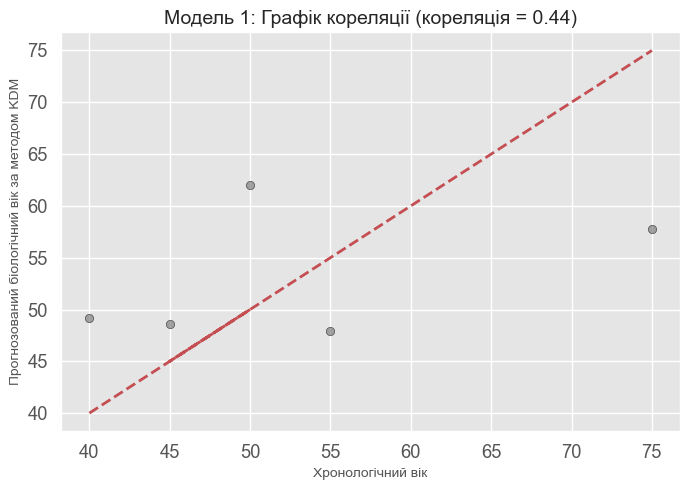

In [37]:
# Створення моделі
model_0_ba = Sequential([
    layers.Dense(128, input_shape=(X_train_scaled.shape[1],)),
    layers.PReLU(),
    layers.Dense(64),
    layers.PReLU(),
    layers.Dense(16),
    layers.PReLU(),
    layers.Dense(1),
])

# Компільований оптимізатор
model_0_ba.compile(loss='mae', optimizer=optimizers.Adagrad(0.01),
                   metrics=[metrics.MeanSquaredError(), metrics.MeanAbsoluteError()])

# Колбеки
custom_metrics_callback = CustomMetricsCallback()
custom_metrics_callback.X_test = X_test_scaled
custom_metrics_callback.y_test = y_test['Age']
custom_metrics_callback.loss_name = 'MAE'
custom_metrics_callback.epoch_count = 50

callback_stoping = callbacks.EarlyStopping(monitor='loss', patience=5)

# Навчання
start_time = time.time()

history = model_0_ba.fit(X_train_scaled, y_train['Age'], epochs=1000, batch_size=25, 
                         callbacks=[custom_metrics_callback, callback_stoping], verbose=0)

execution_time = time.time() - start_time

# Прогноз
prediction = model_0_ba.predict(X_test_scaled)

show_result(y_test['Age'], prediction, execution_time,
            'Модель 1: Графік кореляції',
            'Хронологічний вік',
            'Прогнозований біологічний вік за методом KDM')

In [39]:
# target_column_name = "Age"
# X = df_male.drop(columns=[target_column_name])
# y = df_male[[target_column_name]]

# # Split whole data to train and remainings
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# # Split remainings data to val and test
# # X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# Covert data to torch tensor
train_input = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
train_label = torch.tensor(y_train.to_numpy()[:, None], dtype=torch.float32)
# val_input = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
# val_label = torch.tensor(y_val.to_numpy()[:, None], dtype=torch.float32)
test_input = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
test_label = torch.tensor(y_test.to_numpy()[:, None], dtype=torch.float32)

train_label = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
# val_label = torch.tensor(y_val.to_numpy(), dtype=torch.float32)
test_label = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

dataset = {
    'train_input': train_input,
    'train_label': train_label,
    # 'val_input': val_input,
    # 'val_label': val_label,
    'test_input': test_input,
    'test_label': test_label
}


def evaluate_metrics(execution_time, preds, labels, label=""):
    preds_np = preds.numpy()
    labels_np = labels.numpy()

    r2 = r2_score(labels_np, preds_np)
    mae = mean_absolute_error(labels_np, preds_np)
    mse = mean_squared_error(labels_np, preds_np)
    corr, _ = pearsonr(labels_np.flatten(), preds_np.flatten())  # Flatten для векторів

    print(f"{label} R2: {r2}")
    print(f"{label} MAE: {mae}")
    print(f"{label} MSE: {mse}")
    print(f"{label} Correlation: {corr}")
    print(f"Time: {execution_time}")
    print("-" * 50)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.36e+00 | test_loss: 3.13e+00 | reg: 2.54e+01 | : 100%|█| 20/20 [00:45<00:00,  2.28s/


saving model version 0.1
KAN(width=[3,3,1], grid=3, k=5)
Model results:
R2: 0.23701846599578857
MAE: 9.774874687194824 | MAX:  13.385384 | MIN:  2.723053
MSE: 111.39530181884766
Correlation: 0.5005212427786617
Час виконання: 48.36420440673828 секунд.
|Real age       |Predicted      |
|---------------|---------------|
|40.000         |51.749         |
|50.000         |62.906         |
|45.000         |47.723         |
|55.000         |46.889         |
|75.000         |61.615         |


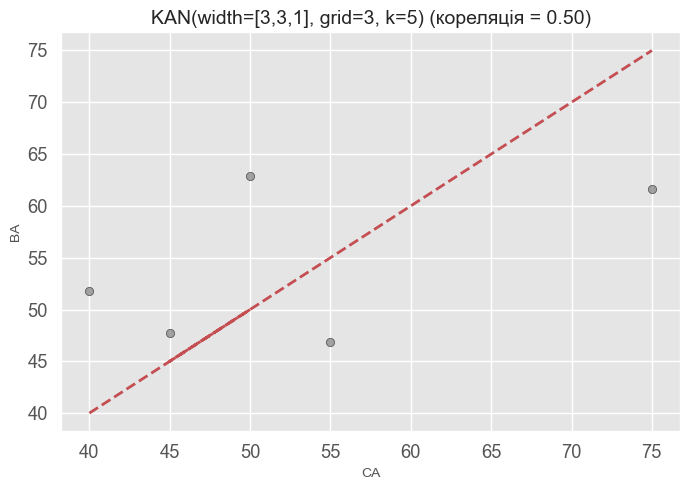

In [40]:
# Create KAN
#biomarkers = 6
biomarkers = 3
count_layers = 3
pam = 1
grid = 3
k = 5

model = KAN(width=[biomarkers, count_layers, 1], grid=3, k=3)

model_name = 'KAN(width=[' + str(biomarkers) + "," + str(count_layers) + ',1], ' + 'grid=' + str(grid) + ", k=" + str(k) + ')'

start_time = time.time()

results = model.fit({
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label},
                    opt="LBFGS",
                    loss_fn=torch.nn.L1Loss(),
                    steps=20, lr=0.001, lamb=0.01, lamb_entropy=2.0)

end_time = time.time()
execution_time = end_time - start_time

# train_preds = model.forward(train_input).detach().numpy()
# train_labels = train_label.numpy()

test_preds = model.forward(test_input).detach().numpy()
test_labels = pd.Series(test_label.numpy().ravel())

print(model_name)
show_result(test_labels, test_preds, execution_time,
            model_name,
            'CA',
            'BA')

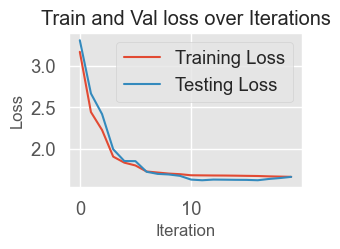

In [147]:
plt.figure(figsize=(3, 2))
plt.plot(results["train_loss"], label='Training Loss')
plt.plot(results["test_loss"], label='Testing Loss')
plt.title('Train and Val loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

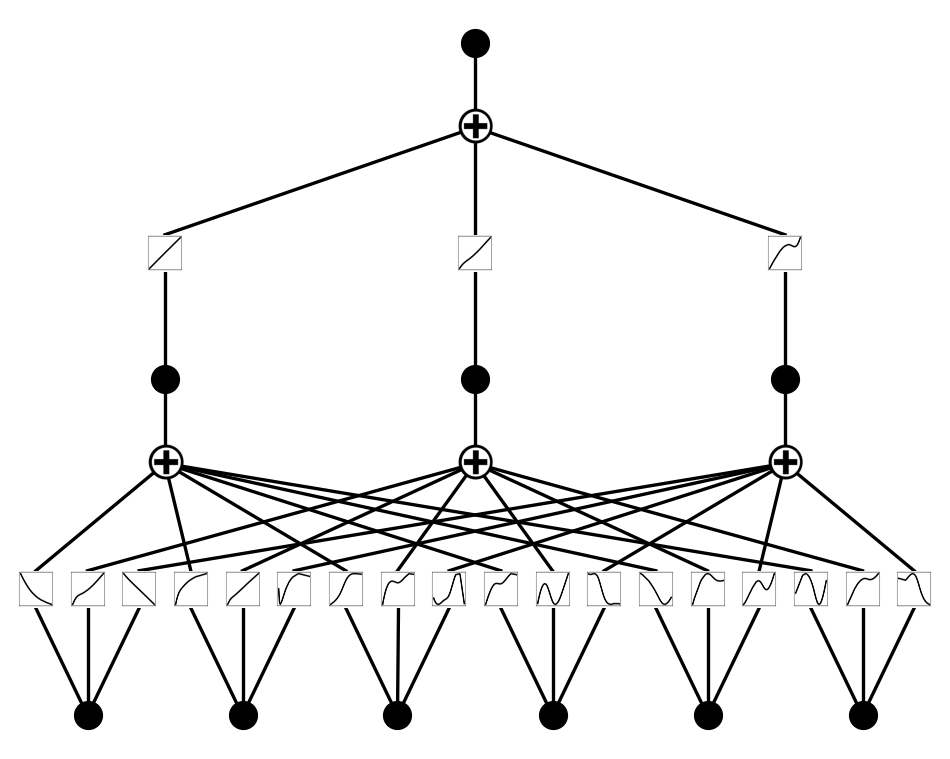

In [154]:
model.plot(scale=1.2, beta=10000000)